In [78]:
import tomli
import numpy as np
import pandas as pd
import glob
import math
import csv
import os
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from collections import Counter

In [2]:
with open("config.toml", "rb") as f:
    config = tomli.load(f)

In [3]:
train_info = pd.read_csv(config['Train']['InfoFile'])
train_info.head()

,unique_id,player_id,mode,gender,hold racket handed,play years,level,cut_point
0,1,41,1,1,1,1,5,[ 0 61 122 183 244 305 366 428 489 ...
1,2,41,2,1,1,1,5,[ 0 74 149 224 299 374 449 524 599 ...
2,3,41,3,1,1,1,5,[ 0 103 207 311 415 519 623 727 831 ...
3,4,41,4,1,1,1,5,[ 0 101 203 304 406 507 609 710 812 ...
4,5,41,5,1,1,1,5,[ 0 105 211 317 423 529 635 740 846 ...


In [87]:
Counter(train_info['level'])

Counter({5: 903, 2: 715, 3: 201, 4: 136})

In [4]:
unique_players = train_info['player_id'].unique()
train_players, test_players = train_test_split(unique_players, test_size=0.2, random_state=42)

# 讀取特徵 CSV 檔（位於 "./tabular_data_train"）
datapath = './tabular_data_train'
datalist = glob.glob(os.path.join(config['Train']['FeaturePath'], "*.csv"))
target_mask = ['gender', 'hold racket handed', 'play years', 'level']

In [5]:
sample_file = pd.read_csv(datalist[0])
sample_file.head()

,ax_mean,ay_mean,az_mean,gx_mean,gy_mean,gz_mean,ax_var,ay_var,az_var,gx_var,...,a_fft,g_fft,a_psd,g_psd,a_kurt,g_kurt,a_skewn,g_skewn,a_entropy,g_entropy
0,-3210.325581,-1472.639535,769.174419,3888.139535,15000.069767,-1508.011628,2625.734377,2141.530712,2579.672441,22376.099388,...,34235.187587,34235.187587,8.524912e+09,8.524912e+09,7.929079,2.715360,193.153135,63.072307,-0.055732,-0.055732
1,-4266.151163,-1758.790698,433.104651,4868.604651,14022.290698,3694.767442,2716.650412,3104.921440,2033.799252,23827.776754,...,4200.628815,4200.628815,2.855087e+08,2.855087e+08,4.805886,3.387055,116.344046,86.140297,-0.055453,-0.055453
2,-3777.058140,-2363.441860,496.430233,3838.127907,17846.848837,2016.662791,2646.756001,2342.910897,2150.277547,25096.946277,...,8077.753674,8077.753674,2.063152e+08,2.063152e+08,3.828190,2.898664,113.018318,54.248883,-0.056366,-0.056366
3,-3545.058140,-1156.709302,618.046512,3811.674419,14340.662791,3557.930233,2507.900301,2258.403467,1908.365970,22559.762748,...,5265.867665,5265.867665,1.557855e+08,1.557855e+08,2.039432,3.110605,30.070979,67.902479,-0.056986,-0.056986
4,-3078.068966,-793.758621,137.551724,10518.264368,9810.137931,-9929.160920,2518.215706,2126.238452,1811.472957,19047.955661,...,1315.209915,1315.209915,6.176466e+07,6.176466e+07,8.145404,5.094156,205.116213,137.770788,-0.057376,-0.057376


In [6]:
# 根據 test_players 分組資料
x_train = pd.DataFrame()
y_train = pd.DataFrame(columns=target_mask)
x_test = pd.DataFrame()
y_test = pd.DataFrame(columns=target_mask)

for file in datalist:
    unique_id = int(Path(file).stem)
    row = train_info[train_info['unique_id'] == unique_id]
    if row.empty:
        continue
    player_id = row['player_id'].iloc[0]
    data = pd.read_csv(file)
    target = row[target_mask]
    target_repeated = pd.concat([target] * len(data))
    if player_id in train_players:
        x_train = pd.concat([x_train, data], ignore_index=True)
        y_train = pd.concat([y_train, target_repeated], ignore_index=True)
    elif player_id in test_players:
        x_test = pd.concat([x_test, data], ignore_index=True)
        y_test = pd.concat([y_test, target_repeated], ignore_index=True)

In [7]:
# 標準化特徵
scaler = MinMaxScaler()
le = LabelEncoder()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

group_size = 27

In [8]:
x_train.head()

,ax_mean,ay_mean,az_mean,gx_mean,gy_mean,gz_mean,ax_var,ay_var,az_var,gx_var,...,a_fft,g_fft,a_psd,g_psd,a_kurt,g_kurt,a_skewn,g_skewn,a_entropy,g_entropy
0,-3210.325581,-1472.639535,769.174419,3888.139535,15000.069767,-1508.011628,2625.734377,2141.530712,2579.672441,22376.099388,...,34235.187587,34235.187587,8.524912e+09,8.524912e+09,7.929079,2.715360,193.153135,63.072307,-0.055732,-0.055732
1,-4266.151163,-1758.790698,433.104651,4868.604651,14022.290698,3694.767442,2716.650412,3104.921440,2033.799252,23827.776754,...,4200.628815,4200.628815,2.855087e+08,2.855087e+08,4.805886,3.387055,116.344046,86.140297,-0.055453,-0.055453
2,-3777.058140,-2363.441860,496.430233,3838.127907,17846.848837,2016.662791,2646.756001,2342.910897,2150.277547,25096.946277,...,8077.753674,8077.753674,2.063152e+08,2.063152e+08,3.828190,2.898664,113.018318,54.248883,-0.056366,-0.056366
3,-3545.058140,-1156.709302,618.046512,3811.674419,14340.662791,3557.930233,2507.900301,2258.403467,1908.365970,22559.762748,...,5265.867665,5265.867665,1.557855e+08,1.557855e+08,2.039432,3.110605,30.070979,67.902479,-0.056986,-0.056986
4,-3078.068966,-793.758621,137.551724,10518.264368,9810.137931,-9929.160920,2518.215706,2126.238452,1811.472957,19047.955661,...,1315.209915,1315.209915,6.176466e+07,6.176466e+07,8.145404,5.094156,205.116213,137.770788,-0.057376,-0.057376


In [16]:
feature_names = x_train.columns.to_list()

In [10]:
def plot_input_importance(model, feature_names=None):
    first_layer = next(model.parameters()).detach().cpu()  # Shape: [hidden_dim, input_dim]
    importance = first_layer.abs().mean(dim=0)  # Mean importance across neurons

    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(len(importance))]

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(importance)), importance.numpy(), tick_label=feature_names)
    plt.xticks(rotation=45)
    plt.ylabel("Average |Weight|")
    plt.title("Input Feature Importance (First Layer Weights)")
    plt.tight_layout()
    plt.show()

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np

# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# Define a simple neural network for binary classification
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, **model_config):
        super(BinaryClassifier, self).__init__()
        hidden_dim=model_config.get('hidden_dim',128)
        dropout=model_config.get('dropout',128)
        num_layers=model_config.get('num_layers',128)
        layers = []
        input_dim = input_size
        for i in range(num_layers):
            linear = nn.Linear(input_dim, hidden_dim)
            
            layers.extend([
                linear,
                nn.Tanh(),
                nn.Dropout(dropout)
            ])
            input_dim = hidden_dim
            
        # Final classification layer
        final_layer = nn.Linear(hidden_dim, 1)
        nn.init.xavier_uniform_(final_layer.weight)
        nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Define a neural network for multi-class classification
class MultiClassifier(nn.Module):
    def __init__(self, input_size, num_classes,**model_config):
        super(MultiClassifier, self).__init__()
        hidden_dim=model_config.get('hidden_dim',128)
        dropout=model_config.get('dropout',0.2)
        num_layers=model_config.get('num_layers',1)
        layers = []
        input_dim = input_size
        for i in range(num_layers):
            linear = nn.Linear(input_dim, hidden_dim)
            
            layers.extend([
                linear,
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            input_dim = hidden_dim
        # Create a funnel shape for the model
        # for i in range(num_layers):
        #     linear = nn.Linear(input_dim, hidden_dim)
            
        #     layers.extend([
        #         linear,
        #         nn.Tanh(),
        #         nn.Dropout(dropout)
        #     ])
        #     input_dim = hidden_dim
        #     # Reduce hidden_dim to create a funnel shape
        #     hidden_dim = max(1, hidden_dim // 2)
        # Final classification layer
        final_layer = nn.Linear(hidden_dim, num_classes)
        nn.init.xavier_uniform_(final_layer.weight)
        nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        self.model = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        logits = self.model(x)
        return logits
    
    def predict_proba(self, x):
        logits = self.model(x)
        return self.softmax(logits)

# Function to train binary classification model with early stopping (using validation loss)
def train_binary_model(X_train, y_train, X_val, y_val, batch_size=64, epochs=30, lr=0.001, patience=5, min_delta=1e-4,weights=None,model_config=None):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val.reshape(-1, 1))
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    input_size = X_train.shape[1]
    if model_config != None:
        model = BinaryClassifier(input_size,**model_config)
    else:
        model = BinaryClassifier(input_size)

    # Loss and optimizer
    if weights != None:
        weight_ratio = [weights[0]/weights[1]]
        torch_weight = torch.FloatTensor(weight_ratio)
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch_weight)
    else:
        criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Training loop with early stopping (monitoring validation loss)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        
        # Compute validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping check (on validation loss)
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        predicted = model(X_val_tensor).numpy().flatten()
    
    # Group predictions
    num_groups = len(predicted) // group_size
    y_pred = []
    for i in range(num_groups):
        group_preds = predicted[i*group_size: (i+1)*group_size]
        if sum(group_preds[:group_size]) / group_size > 0.5:
            y_pred.append(max(group_preds))
        else:
            y_pred.append(min(group_preds))
    
    y_val_agg = [y_val[i*group_size] for i in range(num_groups)]
    
    auc_score = roc_auc_score(y_val_agg, y_pred, average='micro')
    print(f'Binary AUC: {auc_score}')
    return model, auc_score

# Function to train multi-class classification model with early stopping (using validation loss)
def train_multi_model(X_train, y_train, X_val, y_val, batch_size=64, epochs=40, lr=0.001, patience=5, min_delta=1e-4,weights=None,model_config=None):
    # Get number of classes
    num_classes = len(np.unique(y_train))
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    input_size = X_train.shape[1]
    if model_config != None:
        model = MultiClassifier(input_size,num_classes,**model_config)
    else:
        model = MultiClassifier(input_size, num_classes)
    
    # Loss and optimizer
    if weights != None:
        torch_weight = torch.FloatTensor(weights)
        criterion = nn.CrossEntropyLoss(weight=torch_weight)
    else:
        criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Training loop with early stopping (monitoring validation loss)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        
        # Compute validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping check (on validation loss)
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        predicted = model.predict_proba(X_val_tensor)
    
    # Group predictions as in your original code
    num_groups = len(predicted) // group_size
    y_pred = []
    for i in range(num_groups):
        group_pred = predicted[i*group_size: (i+1)*group_size]
        class_sums = [sum([group_pred[k][j] for k in range(group_size)]) for j in range(num_classes)]
        chosen_class = np.argmax(class_sums)
        candidate_probs = [group_pred[k][chosen_class] for k in range(group_size)]
        best_instance = np.argmax(candidate_probs)
        y_pred.append(group_pred[best_instance])
    
    y_val_agg = [y_val[i*group_size] for i in range(num_groups)]
    
    auc_score = roc_auc_score(y_val_agg, y_pred, average='micro', multi_class='ovr')
    print(f'Multi-class AUC: {auc_score}')
    return model, auc_score

In [119]:
multi_configs = [
    # {
    #     "hidden_dim" : 32,
    #     "num_layers" : 2,
    #     "dropout" : 0.2,
    # },
    {
        "hidden_dim" : 1024,
        "num_layers" : 1,
        "dropout" : 0.2,
    },
    # {
    #     "hidden_dim" : 256,
    #     "num_layers" : 2,
    #     "dropout" : 0.2,
    # },
]

In [120]:
# For binary classification (gender)
# y_train_le_gender = le.fit_transform(y_train['gender'])
# y_test_le_gender = le.transform(y_test['gender'])
# gender_model, gender_auc = train_binary_model(X_train_scaled, y_train_le_gender, X_test_scaled, y_test_le_gender,weights=[1600,300], model_config=binary_configs[0])

# # For binary classification (hold racket handed)
# y_train_le_hold = le.fit_transform(y_train['hold racket handed'])
# y_test_le_hold = le.transform(y_test['hold racket handed'])
# hold_model, hold_auc = train_binary_model(X_train_scaled, y_train_le_hold, X_test_scaled, y_test_le_hold,weights=[1600,350])

# # For multi-class classification (play years)
# y_train_le_years = le.fit_transform(y_train['play years'])
# y_test_le_years = le.transform(y_test['play years'])
# for conf in multi_configs:
#     years_auc_list = []
#     for i in range(0, 10):
#         years_model, years_auc = train_multi_model(X_train_scaled, y_train_le_years, X_test_scaled, y_test_le_years,weights=[387,868,700],model_config=conf)
#         years_auc_list.append(years_auc)
    
#     years_auc_mean = np.mean(years_auc_list)
#     years_auc_std = np.std(years_auc_list)
    
#     print(f'Years AUC Mean: {years_auc_mean}, Years AUC Std: {years_auc_std}')

# # For multi-class classification (level)
y_train_le_level = le.fit_transform(y_train['level'])
y_test_le_level = le.transform(y_test['level'])
for conf in multi_configs:
    level_auc_list = []
    for i in range(0, 10):
        level_model, level_auc = train_multi_model(X_train_scaled, y_train_le_level, X_test_scaled, y_test_le_level,weights=[715,201,136,903],model_config=conf)
        level_auc_list.append(level_auc)
    
    level_auc_mean = np.mean(level_auc_list)
    level_auc_std = np.std(level_auc_list)
    
    print(f'level AUC Mean: {level_auc_mean}, level AUC Std: {level_auc_std}')

Epoch 1/40, Train Loss: 0.5504, Val Loss: 0.6882
Epoch 2/40, Train Loss: 0.4481, Val Loss: 0.5783
Epoch 3/40, Train Loss: 0.3909, Val Loss: 0.6005
Epoch 4/40, Train Loss: 0.3538, Val Loss: 0.6535
Epoch 5/40, Train Loss: 0.3291, Val Loss: 0.6485
Epoch 6/40, Train Loss: 0.3043, Val Loss: 0.6239
Epoch 7/40, Train Loss: 0.2898, Val Loss: 0.6809
Early stopping at epoch 7
Multi-class AUC: 0.8497344343156318
Epoch 1/40, Train Loss: 0.5481, Val Loss: 0.6543
Epoch 2/40, Train Loss: 0.4457, Val Loss: 0.5761
Epoch 3/40, Train Loss: 0.3892, Val Loss: 0.5774
Epoch 4/40, Train Loss: 0.3487, Val Loss: 0.6569
Epoch 5/40, Train Loss: 0.3202, Val Loss: 0.6655
Epoch 6/40, Train Loss: 0.3019, Val Loss: 0.6310
Epoch 7/40, Train Loss: 0.2876, Val Loss: 0.7333
Early stopping at epoch 7
Multi-class AUC: 0.8500143094029613
Epoch 1/40, Train Loss: 0.5535, Val Loss: 0.6265
Epoch 2/40, Train Loss: 0.4488, Val Loss: 0.6849
Epoch 3/40, Train Loss: 0.3949, Val Loss: 0.6209
Epoch 4/40, Train Loss: 0.3578, Val Loss: 0

In [53]:
gender_auc

np.float64(0.9089539978094195)

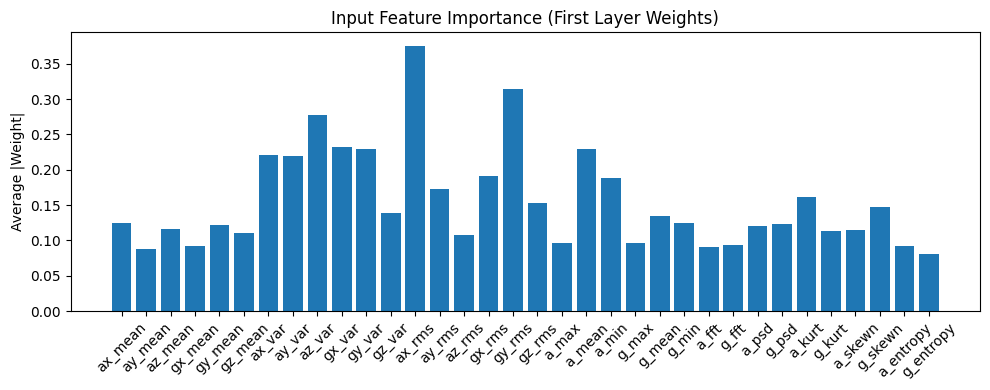

In [69]:
plot_input_importance(gender_model,feature_names=feature_names)

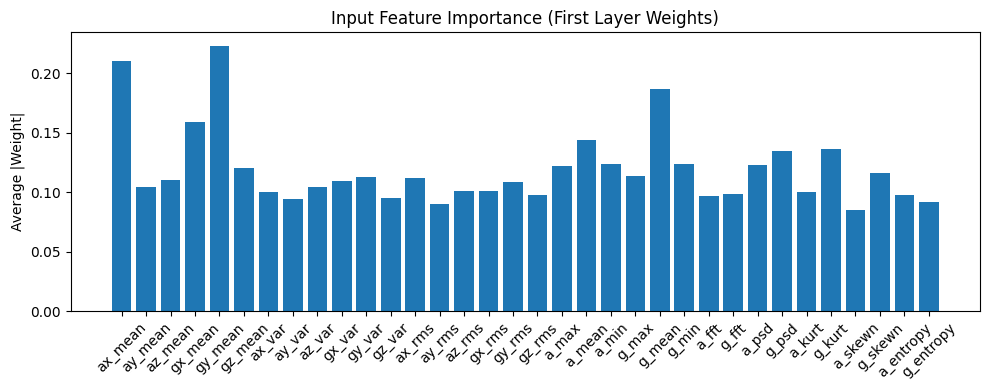

In [29]:
plot_input_importance(hold_model,feature_names=feature_names)

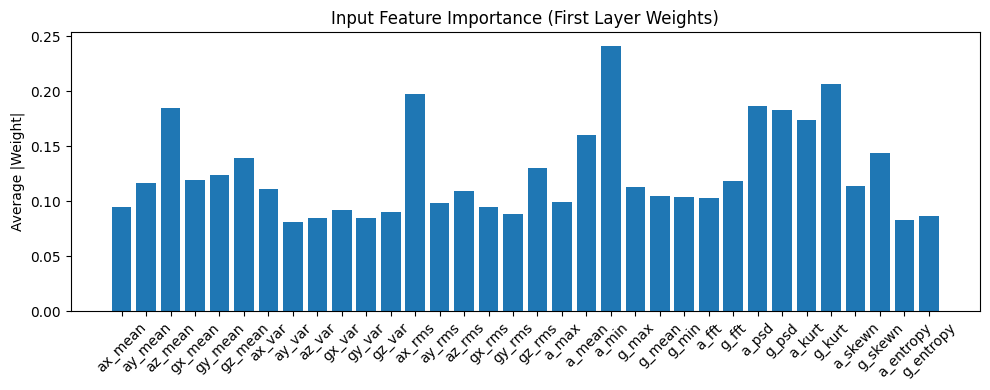

In [85]:
plot_input_importance(years_model,feature_names=feature_names)

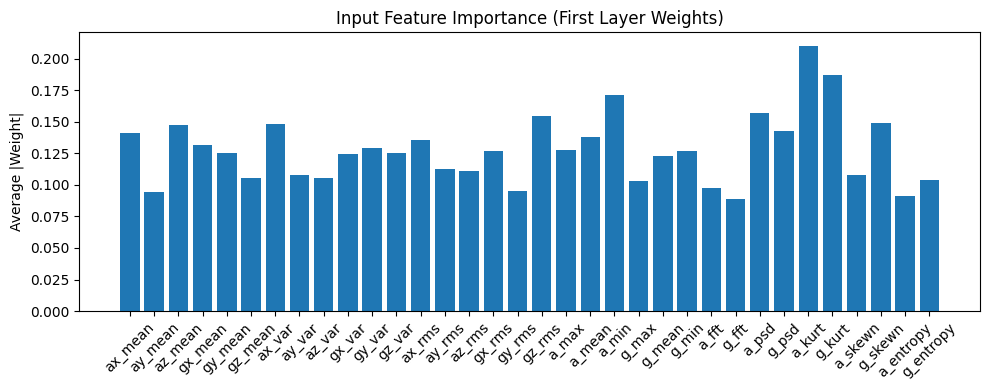

In [31]:
plot_input_importance(level_model,feature_names=feature_names)